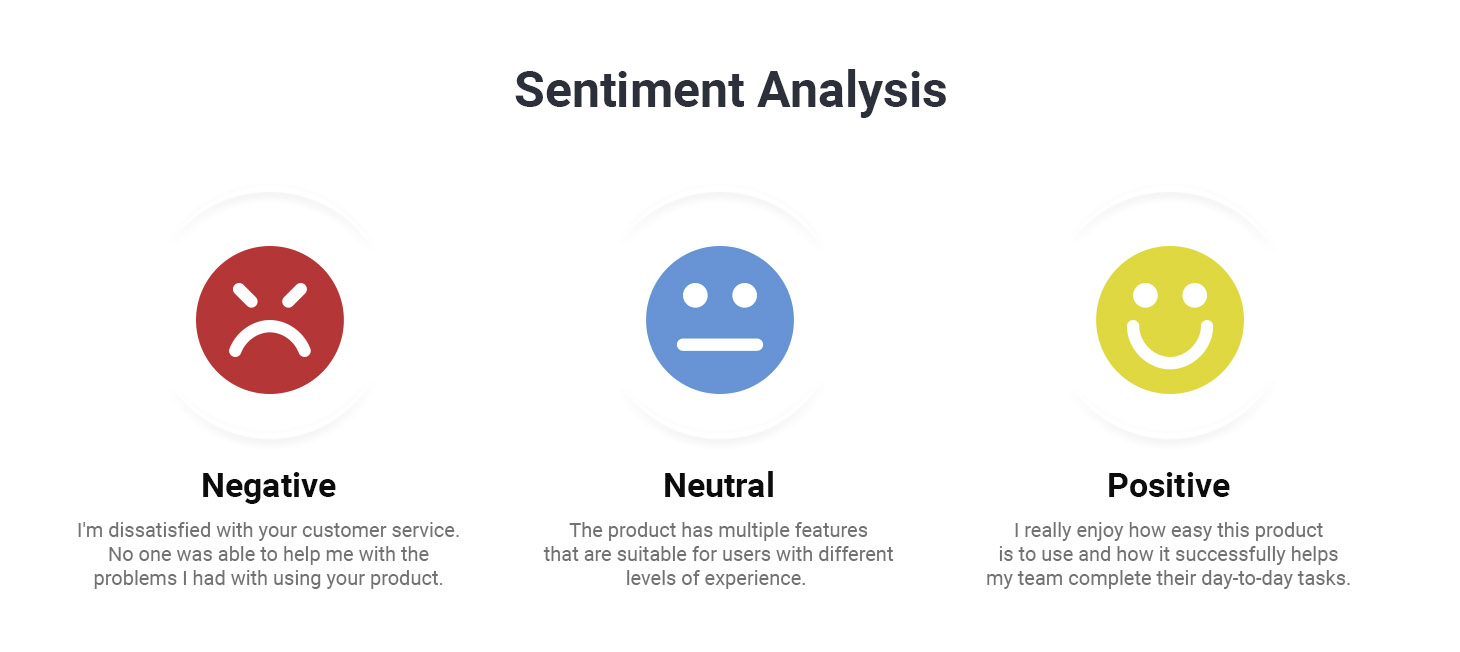

## A Comprehensive Sentiment analysis on US Airlines

Importing all the Libraries

In [1]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import re
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization

In [7]:
# Import twitter data
df = pd.read_csv("Tweets.csv")

In [8]:
# Clean tweets beforehand to improve word cloud, remove user handles, stop words, word less than 3 characters, etc

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [9]:
# remove twitter handles (@user)
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")
# remove special characters, numbers, punctuations
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
# remove words less than 3 characters long
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [10]:
# Stopwords are English words that do not add much meaning to the sentence
comment_words = ' '
stopwords = set(STOPWORDS)

In [11]:
# Create 3 separate dataframes only containing either positive, negative, or neutral tweets
# Positive
pos_df = df[df['airline_sentiment']=='positive']

# Negative
neg_df = df[df['airline_sentiment']=='negative']

# Neutral
neu_df = df[df['airline_sentiment']=='neutral']

In [13]:
# Example of positive tweets with high confidence
pos_high_conf = pos_df[pos_df['airline_sentiment_confidence']==1.0]
print(pos_high_conf['text'][9])
print(pos_high_conf['text'][11])
print(pos_high_conf['text'][12])

@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.
@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D
@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p


In [14]:
# Example of neutral tweet with high confidence
neu_high_conf = neu_df[neu_df['airline_sentiment_confidence']==1.0]
print(neu_high_conf['text'][0])
print(neu_high_conf['text'][23])
print(neu_high_conf['text'][31])

@VirginAmerica What @dhepburn said.
@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?
@VirginAmerica Are the hours of operation for the Club at SFO that are posted online current?


In [15]:
# Example of negative tweet with high confidence
neg_high_conf = neg_df[neg_df['airline_sentiment_confidence']==1.0]
print(neg_high_conf['text'][3])
print(neg_high_conf['text'][4])
print(neg_high_conf['text'][5])

@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA


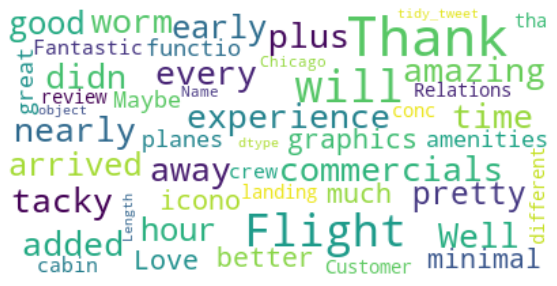

In [16]:
# Positive wordcloud
wordcloud = WordCloud(
                    background_color='white',
                    stopwords=stopwords,
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(pos_df['tidy_tweet']))
 
print(wordcloud)
fig = plt.figure(1, figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

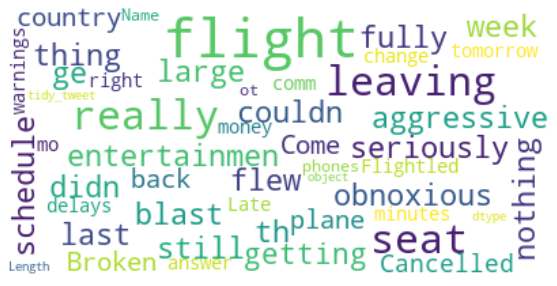

In [17]:

# Negative wordcloud
wordcloud = WordCloud(
                    background_color='white',
                    stopwords=stopwords,
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(neg_df['tidy_tweet']))
 
print(wordcloud)
fig = plt.figure(1, figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

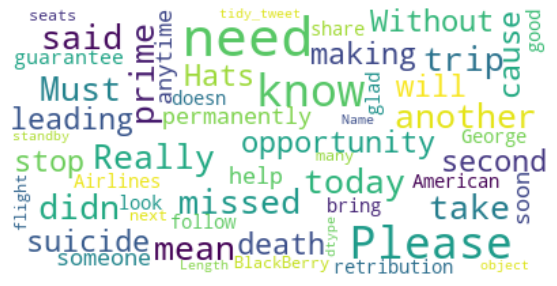

In [18]:
# Neutral 
wordcloud = WordCloud(
                    background_color='white',
                    stopwords=stopwords,
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(neu_df['tidy_tweet']))
 
print(wordcloud)
fig = plt.figure(1, figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## The goal of this project is to classify airline tweets using a pre-trained word embedding from GloVe and RNN(LSTM and GRU) 

In [27]:
# Import twitter data
tweet_data = pd.read_csv("Tweets.csv")

In [28]:
# Example of tweets
tweet_data['text'].head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

There are 14,640 rows and 15 columns. The included features are: tweet id, sentiment, sentiment confidence score, negative reason, negative reason confidence, airline, sentiment gold, name, retweet count, tweet text, tweet coordinates, time of tweet, date of tweet, tweet location, and user time zone.

In [29]:
tweet_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [30]:
tweet_data.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [31]:
# Number of rows and columns of data
tweet_data.shape

(14640, 15)

In [32]:
tweet_data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

we are only interested in the text of each tweet and its sentiment label. Therefore, we will remove the extra features of our dataset and keep 2 columns in the end.

In [33]:
tweet_data[['text', 'airline_sentiment']].head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [34]:
# Count number of each type of tweet
tweet_data['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

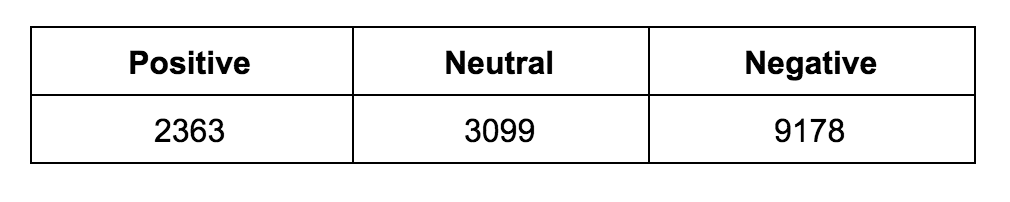

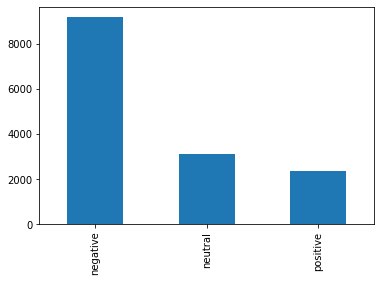

In [35]:
tweet_data['airline_sentiment'].value_counts().plot(kind='bar')

In [36]:
# Convert to integers values
tweet_data['airline_sentiment'] = tweet_data['airline_sentiment'].replace('neutral', 1)
tweet_data['airline_sentiment'] = tweet_data['airline_sentiment'].replace('negative', 0)
tweet_data['airline_sentiment'] = tweet_data['airline_sentiment'].replace('positive', 2)

In [37]:
# Split into text and label
X = tweet_data['text'] # data 
y = tweet_data['airline_sentiment'] # labels

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

Keras Tokenizer class turns a piece of text into a sequence of integers with each integer being the index of a token in a dictionary.
Tokenization is the process of converting sentences into words.

In [39]:
# Convert training data into tensors to feed into neural net
# create tokenizer
token = Tokenizer()
token.fit_on_texts(X)

In [40]:
# Find number of unique words in our tweets
vocab_size = len(token.word_index) + 1
vocab_size  ##Vocabulary size of our dataset is 15,769 words.

15769

1. fit_on_texts Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if we give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index"the" = 1; word_index "cat" = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

2. texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

We don't combine them? Because you almost always fit once and convert to sequences many times. You will fit on training corpus once and use that exact same word_index dictionary at train / eval / testing / prediction time to convert actual text into sequences to feed them to the network. So it makes sense to keep those methods separate.

In [41]:
# integer encode everything
sequences = token.texts_to_sequences(X)

In [42]:
# Find longest tweet in sequences
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [43]:
tweet_num = max_tweet()
tweet_num

30

The longest tweet has 30 words. so, We pad the Sequences.

In [44]:
# each review has a different number of words, so pad sequence with 0's
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

In [45]:
# Convert labels
labels = to_categorical(np.asarray(y))

In [46]:
 #Train test 80:20 split
# training data was then further reduced by 20% to create a validation set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.2, random_state = 0)

In [47]:
# Size of train and test datasets
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (11712, 30)
y_train size: (11712, 3)
X_test size: (2928, 30)
y_test size: (2928, 3)


In [48]:
# load the whole embedding into memory

embeddings_index = dict()
fil = open('C:/ProgramData/Anaconda3/glove.6B/glove.6B.100d.txt',encoding="utf8")
for line in fil:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
fil.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


Because we're using GloVE, need to create a word embedding.We created a matrix of weights for words in the training set and one embedding for each word in the training setwe get all unique words in our training set that is Tokenizer index and we find the corresponding weight vector in GloVe embedding.

In [49]:
# Define size of embedding matrix: number of unique words x embedding dim (100)
embedding_matrix = np.zeros((vocab_size, 100))

# fill in matrix
for word, i in token.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix

In [50]:
# Create embedding layer using embedding matrix
from tensorflow.keras.layers import Embedding
# input is vocab_size, output is 100
# weights from embedding matrix, set trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization

The layers are as follows:

Tokenize : This is not a layer for LSTM network but a mandatory step of converting our words into tokens (integers)
Embedding Layer: that converts our word tokens (integers) into embedding of specific size
LSTM Layer: defined by hidden state dims and number of layers
Fully Connected Layer: that maps output of LSTM layer to a desired output size
softmax Activation Layer: that turns all output values 
Output: softmax output from the last timestep is considered as the final output of this network

There are a few hyper parameters:
embed_dim : The embedding layer encodes the input sequence
into a sequence of dense vectors of dimension embed_dim.
lstm_out : The LSTM transforms the vector sequence into a single vector of size lstm_out, containing information about the entire sequence.
The other hyper parameters like dropout, batch_size are similar to that of CNN.
we used softmax as activation function.


## First Model: Simple LSTM with Dropout and High Dimensionality
This model uses 1 LSTM layer in addition to the previously specified embedding and dense softmax layer. The output dimension for the LSTM layer is 256.  We also included regularization with dropout and recurrent dropout. The dropout rate for input units of the layer is 0.2, while the dropout rate of the recurrent units is 0.5. We trained this model for 100 epochs with a batch size of 256.

In [52]:
lstm_model1 = Sequential()
lstm_model1.add(embedding_layer)
lstm_model1.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_model1.add(Dense(3, activation='softmax'))
lstm_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 1,943,239
Trainable params: 366,339
Non-trainable params: 1,576,900
_________________________________________________________________


Now, we fit my model on training set and check the accuracy on validation set.

In [53]:
history_1 = lstm_model1.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=20, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/20
9369/9369 [==============================] - 24s 3ms/sample - loss: 0.8673 - acc: 0.6168 - val_loss: 0.8361 - val_acc: 0.6291
Epoch 2/20
9369/9369 [==============================] - 20s 2ms/sample - loss: 0.7935 - acc: 0.6650 - val_loss: 0.7045 - val_acc: 0.7200
Epoch 3/20
9369/9369 [==============================] - 19s 2ms/sample - loss: 0.7322 - acc: 0.7062 - val_loss: 0.6803 - val_acc: 0.7243
Epoch 4/20
9369/9369 [==============================] - 18s 2ms/sample - loss: 0.7061 - acc: 0.7186 - val_loss: 0.6441 - val_acc: 0.7465
Epoch 5/20
9369/9369 [==============================] - 17s 2ms/sample - loss: 0.6837 - acc: 0.7215 - val_loss: 0.6189 - val_acc: 0.7571
Epoch 6/20
9369/9369 [==============================] - 18s 2ms/sample - loss: 0.6676 - acc: 0.7327 - val_loss: 0.6074 - val_acc: 0.7618
Epoch 7/20
9369/9369 [==============================] - 18s 2ms/sample - loss: 0.6471 - acc: 0.7374 - val_loss: 0.5943 - val_acc: 

In [54]:
#Find train and test accuracy
loss, accuracy = lstm_model1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_model1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8058
Testing Accuracy:  0.7780


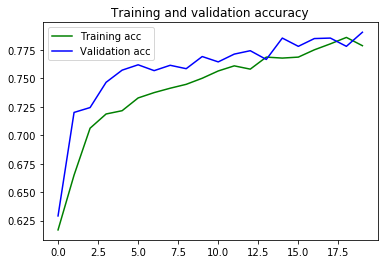

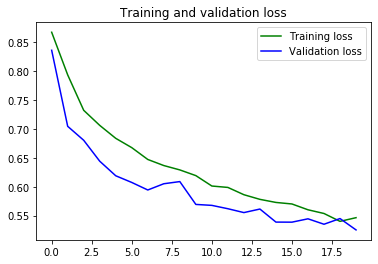

In [55]:
# Plot train/test loss and accuracy
acc = history_1.history['acc']
val_acc = history_1.history['val_acc']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()


In [56]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [57]:
# Get predicted values
y_pred = lstm_model1.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

In [58]:
# Convert y_test to 1d numpy array
y_test_array = np.zeros(X_test.shape[0])

# Find class with 1
for i in range(0, y_test.shape[0]):
    label_predict = np.argmax(y_test[i])
    y_test_array[i] = label_predict

y_test_array = y_test_array.astype(int)

In [59]:
class_names = np.array(['Negative', 'Neutral', 'Positive'])

Confusion matrix, without normalization
[[1672  148   50]
 [ 254  315   45]
 [  89   64  291]]
Normalized confusion matrix
[[0.89 0.08 0.03]
 [0.41 0.51 0.07]
 [0.2  0.14 0.66]]


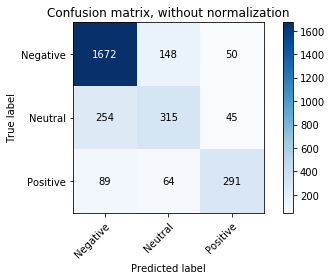

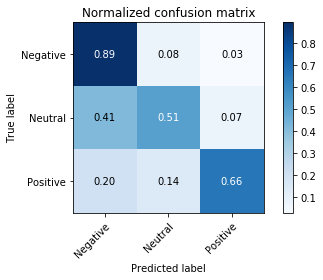

In [60]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Second Model: Simple LSTM with Dropout and Low Dimensionality

we set the number of units for our single LSTM layer to be 64.

In [62]:
lstm_model2 = Sequential()
lstm_model2.add(embedding_layer)
lstm_model2.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_model2.add(Dense(3, activation='softmax'))
lstm_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 1,619,335
Trainable params: 42,435
Non-trainable params: 1,576,900
_________________________________________________________________


In [63]:
history_2 = lstm_model2.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=20, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/20
9369/9369 [==============================] - 7s 758us/sample - loss: 0.8871 - acc: 0.6165 - val_loss: 0.8467 - val_acc: 0.6176
Epoch 2/20
9369/9369 [==============================] - 3s 335us/sample - loss: 0.8415 - acc: 0.6319 - val_loss: 0.8305 - val_acc: 0.6423
Epoch 3/20
9369/9369 [==============================] - 3s 331us/sample - loss: 0.8211 - acc: 0.6498 - val_loss: 0.7781 - val_acc: 0.6679
Epoch 4/20
9369/9369 [==============================] - 3s 334us/sample - loss: 0.7847 - acc: 0.6695 - val_loss: 0.7338 - val_acc: 0.6961
Epoch 5/20
9369/9369 [==============================] - 3s 349us/sample - loss: 0.7547 - acc: 0.6797 - val_loss: 0.6968 - val_acc: 0.70814 - acc
Epoch 6/20
9369/9369 [==============================] - 3s 344us/sample - loss: 0.7259 - acc: 0.6992 - val_loss: 0.6688 - val_acc: 0.7345
Epoch 7/20
9369/9369 [==============================] - 3s 346us/sample - loss: 0.6959 - acc: 0.7134 - val_loss: 0.63

In [64]:
# Find train and test accuracy
loss, accuracy = lstm_model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7916
Testing Accuracy:  0.7725


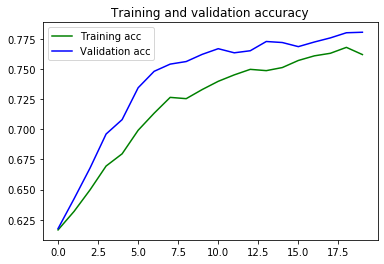

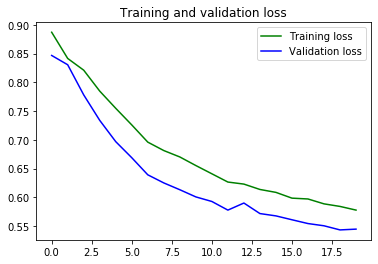

In [65]:
# Plot train/test loss and accuracy
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [66]:

# Get predicted values
y_pred = lstm_model2.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1648  176   46]
 [ 242  323   49]
 [  89   64  291]]
Normalized confusion matrix
[[0.88 0.09 0.02]
 [0.39 0.53 0.08]
 [0.2  0.14 0.66]]


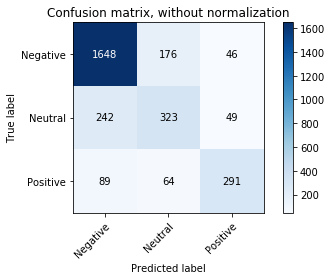

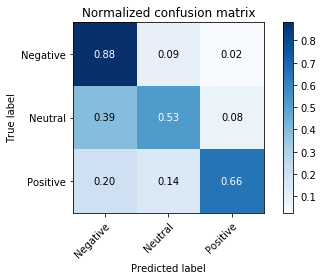

In [67]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Model 3: LSTM Layer Stacking

Because Model 1 does not seem to suffer from overfitting, we can increase the complexity or capacity of the RNN by adding multiple recurrent layers.
Therefore, our third model adds a second LSTM layer with 128 units with 0.2 dropout and 0.5 recurrent dropout


In [68]:
# LSTM Model
model_3 = Sequential()
model_3.add(embedding_layer)
model_3.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_3.add(LSTM(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_3.add(Dense(3, activation='softmax'))
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [69]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 256)           365568    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 2,139,975
Trainable params: 563,075
Non-trainable params: 1,576,900
_________________________________________________________________


In [70]:
history_3 = model_3.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=20, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/20
9369/9369 [==============================] - 43s 5ms/sample - loss: 0.8521 - acc: 0.6304 - val_loss: 0.8054 - val_acc: 0.6773
Epoch 2/20
9369/9369 [==============================] - 40s 4ms/sample - loss: 0.7579 - acc: 0.6880 - val_loss: 0.6797 - val_acc: 0.7409
Epoch 3/20
9369/9369 [==============================] - 40s 4ms/sample - loss: 0.7180 - acc: 0.7053 - val_loss: 0.6701 - val_acc: 0.7350
Epoch 4/20
9369/9369 [==============================] - 40s 4ms/sample - loss: 0.6904 - acc: 0.7209 - val_loss: 0.6501 - val_acc: 0.7379
Epoch 5/20
9369/9369 [==============================] - 40s 4ms/sample - loss: 0.6660 - acc: 0.7331 - val_loss: 0.6167 - val_acc: 0.7550
Epoch 6/20
9369/9369 [==============================] - 40s 4ms/sample - loss: 0.6495 - acc: 0.7360 - val_loss: 0.6010 - val_acc: 0.7623
Epoch 7/20
9369/9369 [==============================] - 40s 4ms/sample - loss: 0.6417 - acc: 0.7397 - val_loss: 0.6099 - val_acc: 

In [71]:
# Find train and test accuracy
loss, accuracy = model_3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8174
Testing Accuracy:  0.7797


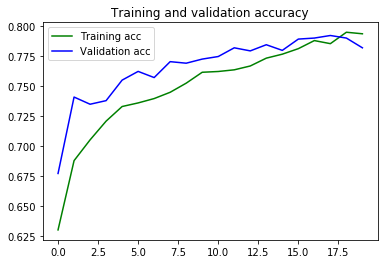

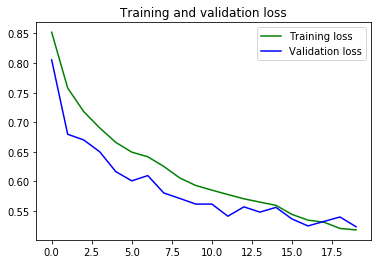

In [72]:
# Plot train/test loss and accuracy
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [73]:
# Get predicted values
y_pred = model_3.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1587  214   69]
 [ 173  386   55]
 [  66   68  310]]
Normalized confusion matrix
[[0.85 0.11 0.04]
 [0.28 0.63 0.09]
 [0.15 0.15 0.7 ]]


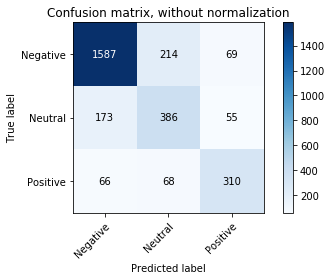

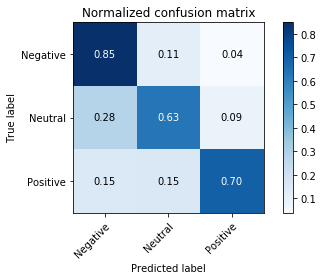

In [74]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Fourth Model: GRU Layer Stacking
Instead of using LSTM layers, we will switch to using GRU. 

In [75]:
# GRU Model 2: reduce number of epochs
model_4 = Sequential()
model_4.add(embedding_layer)
model_4.add(GRU(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_4.add(GRU(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_4.add(Dense(3, activation='softmax'))
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [76]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
gru (GRU)                    (None, 30, 256)           274944    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 2,000,455
Trainable params: 423,555
Non-trainable params: 1,576,900
_________________________________________________________________


In [77]:
history_4 = model_4.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=20, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/20
9369/9369 [==============================] - 41s 4ms/sample - loss: 0.8892 - acc: 0.6179 - val_loss: 0.8470 - val_acc: 0.6176
Epoch 2/20
9369/9369 [==============================] - 32s 3ms/sample - loss: 0.8220 - acc: 0.6483 - val_loss: 0.7579 - val_acc: 0.6786
Epoch 3/20
9369/9369 [==============================] - 32s 3ms/sample - loss: 0.7594 - acc: 0.6818 - val_loss: 0.7022 - val_acc: 0.7089
Epoch 4/20
9369/9369 [==============================] - 32s 3ms/sample - loss: 0.7210 - acc: 0.6976 - val_loss: 0.6523 - val_acc: 0.7354
Epoch 5/20
9369/9369 [==============================] - 32s 3ms/sample - loss: 0.6770 - acc: 0.7274 - val_loss: 0.6003 - val_acc: 0.7631
Epoch 6/20
9369/9369 [==============================] - 32s 3ms/sample - loss: 0.6409 - acc: 0.7388 - val_loss: 0.6120 - val_acc: 0.7537
Epoch 7/20
9369/9369 [==============================] - 32s 3ms/sample - loss: 0.6197 - acc: 0.7508 - val_loss: 0.5770 - val_acc: 

In [78]:
loss, accuracy = model_4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8313
Testing Accuracy:  0.7917


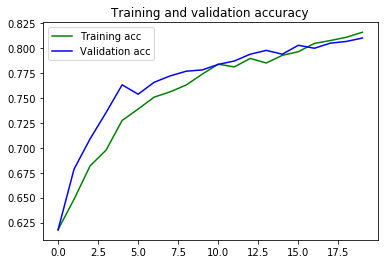

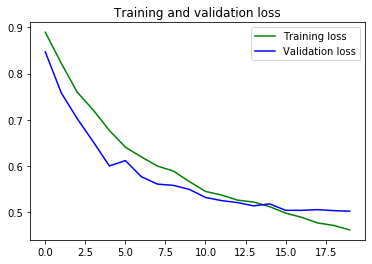

In [79]:
acc = history_4.history['acc']
val_acc = history_4.history['val_acc']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [80]:
# Get predicted values
y_pred = model_4.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1677  112   81]
 [ 246  300   68]
 [  62   41  341]]
Normalized confusion matrix
[[0.9  0.06 0.04]
 [0.4  0.49 0.11]
 [0.14 0.09 0.77]]


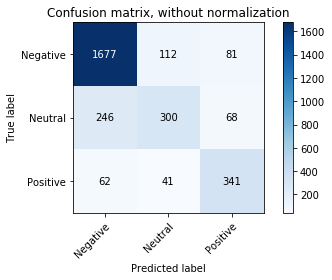

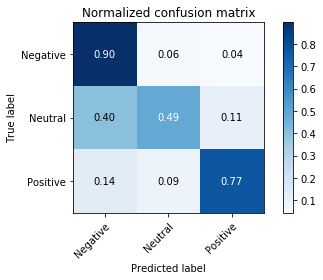

In [81]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Model 5: Reduced GRU with More Regularization

To reduce the overfitting we see in Model 4, we reduce the output dimensions for both the GRU layers to 64 and 32 respectively. Additionally, we increase the dropout in the first GRU layer to be 0.3. 

In [82]:
model_5 = Sequential()
model_5.add(embedding_layer)
model_5.add(GRU(64, 
               dropout = 0.3, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_5.add(GRU(32,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_5.add(Dense(3, activation='softmax'))
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [83]:
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 64)            31872     
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 1,618,279
Trainable params: 41,379
Non-trainable params: 1,576,900
_________________________________________________________________


In [84]:
history_5 = model_5.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=20, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/20
9369/9369 [==============================] - 14s 1ms/sample - loss: 0.9192 - acc: 0.6114 - val_loss: 0.8771 - val_acc: 0.6176
Epoch 2/20
9369/9369 [==============================] - 6s 692us/sample - loss: 0.8651 - acc: 0.6256 - val_loss: 0.8464 - val_acc: 0.6176
Epoch 3/20
9369/9369 [==============================] - 6s 692us/sample - loss: 0.8429 - acc: 0.6375 - val_loss: 0.8258 - val_acc: 0.6564
Epoch 4/20
9369/9369 [==============================] - 7s 703us/sample - loss: 0.8300 - acc: 0.6507 - val_loss: 0.7931 - val_acc: 0.6658
Epoch 5/20
9369/9369 [==============================] - 7s 731us/sample - loss: 0.7921 - acc: 0.6670 - val_loss: 0.7406 - val_acc: 0.6876
Epoch 6/20
9369/9369 [==============================] - 7s 719us/sample - loss: 0.7529 - acc: 0.6781 - val_loss: 0.7154 - val_acc: 0.7029
Epoch 7/20
9369/9369 [==============================] - 6s 690us/sample - loss: 0.7290 - acc: 0.6957 - val_loss: 0.6807 - val

In [85]:
loss, accuracy = model_5.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8027
Testing Accuracy:  0.7821


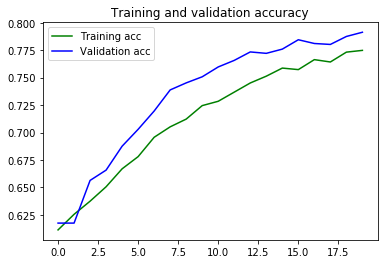

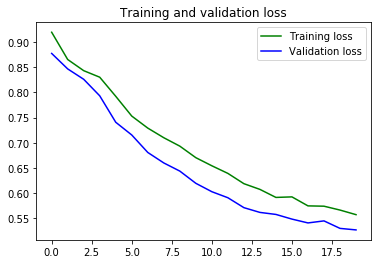

In [86]:
acc = history_5.history['acc']
val_acc = history_5.history['val_acc']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [87]:
# Get predicted values
y_pred = model_5.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1682  137   51]
 [ 245  317   52]
 [  89   64  291]]
Normalized confusion matrix
[[0.9  0.07 0.03]
 [0.4  0.52 0.08]
 [0.2  0.14 0.66]]


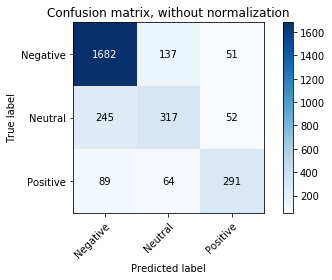

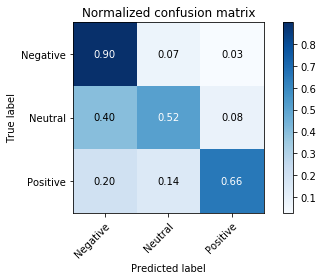

In [88]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Conclusion:

From our analysis, it seems that Model 4 is the best RNN to classify the sentiment of tweets. It does a better job at classifying both neutral and positive tweets compared to our other models. Therefore, it will better generalize to a different dataset that is less overwhelmingly comprised of negative tweets.

## References

1. Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
2. Generating Word Cloud in Python. GeeksforGeeks. https://www.geeksforgeeks.org/generating-word-cloud-python/
3. Francois Chollet. Using pre-trained word embeddings in a Keras model. The Keras Blog. 2016. https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
4. Nikolai Janakiev. Practical Text Classification with Python and Keras. Real Python. 2018. https://realpython.com/python-keras-text-classification/
5. Jason Brownlee. How to Use Word Embedding Layers for Deep Learning with Keras. Machine Learning Mastery. 2017. https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/